# Unsupervised Outlier Detection on Heartbeat graphs

I am using Local Outlier Factor (LOF) method and k-nearest neighbors to do anomaly detection on the graph representation of the heart beat signal.

This notebook, is completing the final step of our pipeline and combining the steps and results of <code>MIT-BIH-Kaggle</code> notebook with <code>KNN_AnomalyDetection_OnGraphs</code> to have a complete process from a raw signal to detect anomalies for each heartbeat of the signal using its coresponding graph.

The outlies are the followings:
1. Create graph stream from the original signal.
2. Compute the pairwise distance between each two graphs and produce the distance matrix using Graph edit distance.
3. Feed the distance matrix for our graph stream into a Local Outlier Factor (LOF) model and detect the abnormal graphs (Each graph corespond to a heartbeat).
4. Compare the detected graph with the ground truth, The actual label of the heartbeat is labeled by expert Cardialogists, and compute the accuracy of our model.

## 1. Graph stream from the original signal.
Lets generate our graph stream from the **MIT-BIH** dataset using the helper functions which implemented  in <code>MIT-BIH-Kaggle</code>.

In [17]:
%reload_ext autoreload
%autoreload
%matplotlib inline
from myHelper import timing
from myHelper import GraphSignalHelper
import numpy as np

data_df = GraphSignalHelper.read_heartbeat_database(name='100', nRowsRead=65000)
annotations_df = GraphSignalHelper.read_annotation_database(name='100')

# downsampling the signal
downstep = 8
(downsp_data_df, downsp_annotations_df) = GraphSignalHelper.downsample(data_df,
                                                                       annotations_df,
                                                                       downstep)


graph_stream, graph_stream_labels = GraphSignalHelper.generate_graph_stream(downsp_data_df, 
                                                                            downsp_annotations_df, 
                                                                            fs = (360 / downstep))
len(graph_stream)
# 2272

221

In [18]:
import networkx as nx
print(nx.info(graph_stream[0]))

Name: 
Type: Graph
Number of nodes: 36
Number of edges: 145
Average degree:   8.0556


## 2. Calculate gragh edit distance matrix
Compute the pairwise distance between each two graphs and produce the distance matrix using Graph edit distance.

In [19]:
from myHelper import timing

# Gmatch4py use networkx graph 
import networkx as nx 
# import the GED using the munkres algorithm
import gmatch4py as gm


@timing.time_it
def GED_distance_matrix(graph_stream):
    # convert from dictionary of graphs to list of graphs
    graph_stream_list = [v for k, v in graph_stream.items()] 
    ged=gm.GraphEditDistance(1,1,1,1) # all edit costs are equal to 1
    non_symetric_GED_matrix=ged.compare(graph_stream_list,None)
    symetric_ged_matrix = (non_symetric_GED_matrix.transpose()+non_symetric_GED_matrix)/2
    return symetric_ged_matrix

distance_matrix = GED_distance_matrix(graph_stream)
print("precomputed distance matrix =\n",distance_matrix)


GED_distance_matrix took 99921.80681228638   mil sec
precomputed distance matrix =
 [[ 0.  63.  51.5 ... 55.5 51.  63.5]
 [63.   0.  60.  ... 64.  54.  56.5]
 [51.5 60.   0.  ... 47.  35.  65.5]
 ...
 [55.5 64.  47.  ...  0.  50.5 61.5]
 [51.  54.  35.  ... 50.5  0.  66. ]
 [63.5 56.5 65.5 ... 61.5 66.   0. ]]


In [20]:
# np.save('Distance_matrix_223_graph', distance_matrix) # save the file as "Distance_matrix_223_graph.npy" 

## 3. Anomaly detection on graphs using distance matrix
Feed the distance matrix for our graph stream into a Local Outlier Factor (LOF) model and detect the abnormal graphs (Each graph corespond to a heartbeat).

## Novelty Detection
I do the novelty detection on train and test dataX_test

In [21]:
from myHelper import anomaly_detection

(X_train, X_test, y_train, y_test) = anomaly_detection.my_train_test_split(graph_stream,
                                                                           graph_stream_labels,
                                                                           test_size=0.33,
                                                                           random_state=42)
y_pred = anomaly_detection.ged_novelty_detection(graph_stream,
                                                 X_test=X_test,
                                                 X_train=X_train,
                                                 n_process= -1)
print("y_pred = ", y_pred)
print("y_test = ", y_test)

X_train shape =  (148, 1)
X_test shape =  (73, 1)
ged_novelty_detection took 98675.01902580261   mil sec
y_pred =  [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1
  1]
y_test =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### To DO
I need to improve it with cross validation and get the accuracy for the whole dataset

## Outlier Detection
I do outlier detection on the whole data of a patient.

In [22]:
from myHelper import anomaly_detection

X_train, y_train = anomaly_detection.get_all_data(graph_stream, graph_stream_labels)

y_pred = anomaly_detection.ged_outlier_detection(graph_stream,
                                                 X_train=X_train,
                                                 n_process= -1)

print("y_pred = ", y_pred)
print("y_train = ", y_train)

X_train shape =  (221, 1)
ged_outlier_detection took 147097.4419116974   mil sec
y_pred =  [ 1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1]
y_train =  [ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  

## 4. Evaluation to the ground truth (labels by Cardiologists)
Compare the detected anomaly graphs with the ground truth, The actual label of the heartbeat is labeled by expert Cardialogists, and compute the accuracy of our model.

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

X_train, y_train = anomaly_detection.get_all_data(graph_stream, graph_stream_labels)
y_pred = anomaly_detection.ged_outlier_detection(graph_stream,
                                                 X_train=X_train,
                                                 n_process= -1)
y_true = y_train

print("Confusion matrix = \n", confusion_matrix(y_true, y_pred))
n_errors = (y_pred != y_true).sum()
print('\nNumber of errors = ', n_errors)
print('\naccuracy =' , round(1 - (n_errors / len(y_true)),4))

# F1 Score
#print("F1 score", round(f1_score(y_valid,pred, average='binary'), 4))
precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_true, 
                                                                         y_pred, 
                                                                         average='binary')
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))

X_train shape =  (221, 1)
ged_outlier_detection took 147053.98893356323   mil sec
Confusion matrix = 
 [[  0   1]
 [  3 217]]

Number of errors =  4

accuracy = 0.9819
precision  0.9954
recall  0.9864
F1 score on Test 0.9909


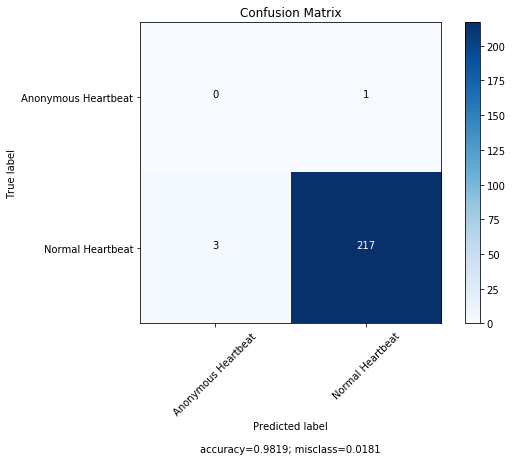

In [24]:
from myHelper import My_confusion_matrix_plotter
My_confusion_matrix_plotter.confusion_matrix_plotter(cm           = confusion_matrix(y_true, 
                                                                                     y_pred), 
                                                     normalize    = False,
                                                     target_names = ['Anonymous Heartbeat', 
                                                                     'Normal Heartbeat'],
                                                     title        = "Confusion Matrix")

In [25]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print('True Negative (Anomalous) = ', tn)
print('False Negative (Anomalous) =', fn)
print('False Positive (Normal)=', fp)
print('True Positive (Normal)=', tp)

True Negative (Anomalous) =  0
False Negative (Anomalous) = 3
False Positive (Normal)= 1
True Positive (Normal)= 217


## Optimize num of neighbors hyper paramter for best F1 score

In [26]:
import pandas as pd
from myHelper import anomaly_detection
min_NN = 2
max_NN = 40
    
EpsF1 = []
y_true = graph_stream_labels

for try_NN in range(min_NN,max_NN,5):
    X_train, y_train = anomaly_detection.get_all_data(graph_stream, graph_stream_labels)
    y_pred = anomaly_detection.ged_outlier_detection(graph_stream,
                                                     X_train=X_train,
                                                     n_process= -1,
                                                     n_neighbors = try_NN)
    y_true = y_train
    
    n_errors = (y_pred != y_true).sum()
    
    precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_true, 
                                                                             y_pred, 
                                                                             average='binary')
    EpsF1.append([try_NN, round(fbeta_score,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['NumNeighb', 'F1'])
EpsF1df.head()

X_train shape =  (221, 1)
ged_outlier_detection took 136668.72024536133   mil sec
X_train shape =  (221, 1)
ged_outlier_detection took 137506.8678855896   mil sec
X_train shape =  (221, 1)
ged_outlier_detection took 136833.98485183716   mil sec
X_train shape =  (221, 1)
ged_outlier_detection took 137063.0760192871   mil sec
X_train shape =  (221, 1)
ged_outlier_detection took 136049.35765266418   mil sec
X_train shape =  (221, 1)
ged_outlier_detection took 136427.03080177307   mil sec
X_train shape =  (221, 1)
ged_outlier_detection took 138121.80519104004   mil sec
X_train shape =  (221, 1)
ged_outlier_detection took 146146.5301513672   mil sec


,NumNeighb,F1
0,2,0.9955
1,7,0.9909
2,12,0.9909
3,17,0.9909
4,22,0.9909


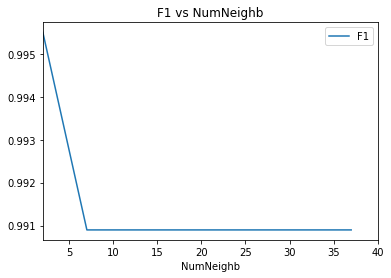

In [29]:
from matplotlib import pyplot as plt
EpsF1df.plot.line("NumNeighb","F1")
plt.xlim(2, 40)
plt.title("F1 vs NumNeighb")
plt.show()

Now I know that the optimal number of neighbors for our case is 2.

## Compute the ROC and AUC

To do:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc